In [22]:
# All import statements
import configparser
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [23]:
def collect_data(folder):
    
    # Create blank dataframe to hold all data
    collected_data = pd.DataFrame()

    # Convert inputted folder string into a directory path
    directory = os.fsencode(folder)
    
    # Loop through all files in folder
    for file in os.listdir(directory):

        # Decode file and directory path from bytes to string and store the season year for future use
        file = file.decode('utf-8')
        folder = directory.decode('utf-8')
        year = file[:4]
        
        # Read the file into a dataframe
        df_current_season = pd.read_excel(folder + '/' + file)

        # Add the season year to the dataframe
        df_current_season['Year'] = year

        # Add dataframe into combined dataframe
        collected_data = pd.concat([collected_data, df_current_season])

    return collected_data

In [24]:
def clean_season_data(season_data):

    # Remove asterisks from Team column in season data, remove Rank column
    season_data.drop(columns = ['Rk'], inplace = True)
    season_data.rename(columns = {'Unnamed: 1': 'Team'}, inplace = True)
    season_data['Team'] = season_data['Team'].str.replace('*', '')
    
    # Drop columns that contain the same data for each team or are summarized by other columns
    season_data.drop(columns = ['GP', 'W', 'L', 'OL', 'PTS%', 'GF', 'GA', 'SOW', 'SOL'], inplace = True)

    return season_data

In [25]:
def clean_playoff_data(playoff_data):
    
    # Remove unnamed columns
    playoff_data = playoff_data[['Team 1', 'Team 2', 'Winner', 'Year']]

    # Trim leading/trailing spaces from columns
    playoff_data = playoff_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    
    return playoff_data

In [26]:
def combine_dataframes(season_data, playoff_data):

    # Merge Team 1 data and add Team 1 prefix for merged columns
    df_combined = pd.merge(playoff_data, season_data, how = 'inner', left_on = ['Team 1', 'Year'], right_on = ['Team', 'Year'])
    new_column_names = [(i, 'Team 1 ' + i) for i in df_combined.iloc[:, 4:].columns.values]
    df_combined.rename(columns = dict(new_column_names), inplace = True)

    # Merge Team 2 data and add Team 2 prefix for merged columns
    df_combined = pd.merge(df_combined, season_data, how = 'inner', left_on = ['Team 2', 'Year'], right_on = ['Team', 'Year'])
    new_column_names = [(i, 'Team 2 ' + i) for i in df_combined.iloc[:, 26:].columns.values]
    df_combined.rename(columns = dict(new_column_names), inplace = True)

    return df_combined

In [27]:
def create_ml_dataset(final_data):

    # Choose independent variables to be used for ML model
    X = final_data.iloc[:, np.r_[5:26, 27:48]]

    # Choose dependent variable the ML model will predict
    Y = final_data['Winner']
    
    # Divide model into training and testing splits
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 24)

    return X_train, X_test, Y_train, Y_test

In [28]:
# Set current working directory
cwd = os.getcwd()

# Read config file
config = configparser.ConfigParser()
config.read(cwd + '\\nhl_config.ini')

# Collect season stats and playoff results data
season_data = collect_data(config['DEFAULT']['SeasonStatsFolder'])
playoff_data = collect_data(config['DEFAULT']['PlayoffResultsFolder'])

# Clean season stats and playoff results data
cleaned_season_data = clean_season_data(season_data)
cleaned_playoff_data = clean_playoff_data(playoff_data)

# Create dataframe combining playoff results and season stats
final_data = combine_dataframes(season_data = cleaned_season_data, playoff_data = cleaned_playoff_data)

# Create dataset for machine learning
X_train, X_test, Y_train, Y_test = create_ml_dataset(final_data = final_data)

C:\Users\arair\AppData\Local\Temp\ipykernel_16732\1171808813.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  season_data['Team'] = season_data['Team'].str.replace('*', '')


In [29]:
# Data exploration - view count distribution of winners
final_data['Winner'].value_counts()

1    100
2     88
Name: Winner, dtype: int64

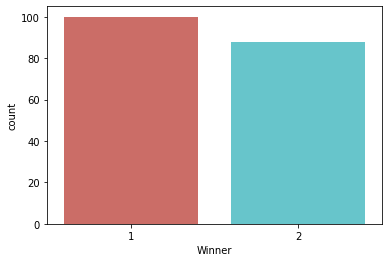

In [30]:
# Data exploration - view distribution of winners
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = 'Winner', data = final_data, palette = 'hls')
plt.show()

In [31]:
# Data exploration - view average for each category by home/away winners
pd.set_option('display.max_columns', None)
final_data.groupby('Winner').mean()

,Team 1 AvAge,Team 1 PTS,Team 1 SRS,Team 1 SOS,Team 1 GF/G,Team 1 GA/G,Team 1 PP,Team 1 PPO,Team 1 PP%,Team 1 PPA,Team 1 PPOA,Team 1 PK%,Team 1 SH,Team 1 SHA,Team 1 PIM/G,Team 1 oPIM/G,Team 1 S,Team 1 S%,Team 1 SA,Team 1 SV%,Team 1 SO,Team 2 AvAge,Team 2 PTS,Team 2 SRS,Team 2 SOS,Team 2 GF/G,Team 2 GA/G,Team 2 PP,Team 2 PPO,Team 2 PP%,Team 2 PPA,Team 2 PPOA,Team 2 PK%,Team 2 SH,Team 2 SHA,Team 2 PIM/G,Team 2 oPIM/G,Team 2 S,Team 2 S%,Team 2 SA,Team 2 SV%,Team 2 SO
Winner,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,28.004000,99.460000,0.506400,-0.025100,3.048700,2.522000,49.540000,243.410000,20.322300,42.24,244.190000,82.746900,6.910000,5.670000,10.122000,10.193000,2398.790000,9.669000,2244.700000,0.914340,6.490,27.910000,90.070,0.197300,-0.006900,2.863200,2.662600,47.540000,242.380000,19.565900,43.610000,237.060000,81.537400,5.880000,5.56,9.682000,9.867000,2352.620000,9.262000,2281.890000,0.911240,5.680000
2,28.130682,98.272727,0.449432,-0.032045,3.029318,2.560114,48.454545,241.647727,20.264091,41.75,242.340909,82.589886,6.420455,5.613636,10.177273,10.188636,2343.147727,9.765909,2228.034091,0.912955,6.125,28.089773,90.875,0.257841,-0.014886,2.803295,2.535114,45.602273,239.738636,19.016591,39.784091,235.590909,83.024091,6.386364,5.50,9.636364,9.796591,2341.795455,9.051136,2216.295455,0.913455,6.431818


In [32]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

estimator = LogisticRegression(max_iter = 10000)
Y_pred = estimator.fit(X_train, Y_train).predict(X_test)
results = classification_report(Y_test, Y_pred)
print(results)

              precision    recall  f1-score   support

           1       0.59      0.67      0.62        30
           2       0.57      0.48      0.52        27

    accuracy                           0.58        57
   macro avg       0.58      0.57      0.57        57
weighted avg       0.58      0.58      0.58        57



In [33]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

estimator = GaussianNB()
Y_pred = estimator.fit(X_train, Y_train).predict(X_test)
results = classification_report(Y_test, Y_pred)
print(results)

              precision    recall  f1-score   support

           1       0.71      0.57      0.63        30
           2       0.61      0.74      0.67        27

    accuracy                           0.65        57
   macro avg       0.66      0.65      0.65        57
weighted avg       0.66      0.65      0.65        57



In [34]:
# Decision Tree
from sklearn import tree
from sklearn.metrics import classification_report

estimator = tree.DecisionTreeClassifier()
Y_pred = estimator.fit(X_train, Y_train).predict(X_test)
results = classification_report(Y_test, Y_pred)
print(results)

              precision    recall  f1-score   support

           1       0.72      0.60      0.65        30
           2       0.62      0.74      0.68        27

    accuracy                           0.67        57
   macro avg       0.67      0.67      0.67        57
weighted avg       0.67      0.67      0.67        57

